<a href="https://colab.research.google.com/github/ihagoSantos/special-topics-in-machine-learning/blob/main/lunar_lander_openai_gym.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys

assert sys.version_info >= (3,7)

In [2]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

In [3]:
import matplotlib.animation
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('animation', html='jshtml')

In [4]:
if not tf.config.list_physical_devices('GPU'):
  print('No GPU was detected. Neural nets cam be very slow without a GPU.')
  if "google.colab" in sys.modules:
    print("Go to Runtime > Change runtime and select a GPU hardware")
  if "kaggle_secrets" in sys.modules:
    print("Go to Settings > Acelerator and select GPU")

No GPU was detected. Neural nets cam be very slow without a GPU.
Go to Runtime > Change runtime and select a GPU hardware


# Gymnasium

In [5]:
if "google.colab" in sys.modules or "kaggle_secrets" in sys.modules:
  %pip install -q -U gymnasium swig
  %pip install -q -U gymnasium[classic_control,box2d,atari,accept-rom-license]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 51.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 17.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [6]:
import gymnasium as gym
import numpy as np

In [7]:
def plot_environment(env, figsize=(5,4)):
  plt.figure(figsize=figsize)
  img = env.render()
  plt.imshow(img)
  plt.axis("off")
  return img

In [9]:
def update_scene(num, frames, patch):
  patch.set_data(frames[num])
  return patch

def plot_animation(frames, repeat=False, interval=40):
  fig = plt.figure()
  patch = plt.imshow(frames[0])
  plt.axis('off')
  anim = matplotlib.animation.FuncAnimation(
      fig, update_scene, fargs=(frames, patch),
      frames=len(frames), repeat=repeat, interval=interval
  )
  plt.close()
  return anim

def show_one_episode(policy, n_max_steps=200, seed=42):
  frames=[]
  env = gym.make("CartPole-v1", render_mode="rgb_array")
  np.random.seed(seed)
  obs, info = env.reset(seed=seed)
  for step in range(n_max_steps):
    frames.append(env.render())
    action = policy(obs)
    obs, reward, done, truncated, info = env.step(action)
    if done or truncated:
      break

  env.close()
  return plot_animation(frames)

Vamos começar criando um ambiente LunarLander-v2:

In [11]:
env = gym.make("LunarLander-v3", render_mode="rgb_array")

As entradas são de 8 dimensões

In [12]:
env.observation_space

Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)

In [14]:
obs, info = env.reset(seed=42)
obs

array([ 0.00229702,  1.4181306 ,  0.2326471 ,  0.3204666 , -0.00265488,
       -0.05269805,  0.        ,  0.        ], dtype=float32)

Aqui [source code](https://www.gymlibrary.dev/environments/box2d/lunar_lander/#lunar-lander) podemos ver cada observação 8D (x,y,h,v,a,w,l,r) coresponde a:
- x,y: as coordenadas da nave espacial. Ela começa em um local aleatório próximo a (0, 1.4) e deve pousar próximo ao alvo em (0,0).
- h,v: a velocidade horizontal e vertical da nave espacial. Começa com uma pequena velocidade aleatória
- a,w: o ângulo e a velocidade angular da nave espacial.
- l,r: se a perna esquerda ou direita toca o chão (1,0) ou não (0,0).

O espaço de ação é discreto, com 4 ações possíveis:



In [15]:
env.action_space

Discrete(4)

Essas ações são:
- fazer nada
- disparar motor de orientação à esquerda
- motor principal de ignição
- disparar motor de orientação à direita

vamos criar uma rede de políticas simples com 4 neurônios de saída (um por ação possível)

In [16]:
np.random.seed(42)
tf.random.set_seed(42)

n_inputs = env.observation_space.shape[0]
n_outputs = env.action_space.n

model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation="relu", input_shape=[n_inputs]),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(n_outputs, activation="softmax")
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
def lander_play_one_step(env, obs, model, loss_fn):
  with tf.GradientTape() as tape:
    probas = model(obs[np.newaxis])
    logits = tf.math.log(probas + tf.keras.backend.epsilon())
    action = tf.random.categorical(logits, num_samples=1)
    loss = tf.reduce_mean(loss_fn(action,probas))
  grads = tape.gradient(loss, model.trainable_variables)
  # env.step returns 4 values: obs, reward, done, info
  obs, reward, done, truncated, info = env.step(action[0, 0].numpy()) # Removed grads from here
  return obs, reward, done, truncated, grads # Included grads in the return statement

def lander_play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
  all_rewards = []
  all_grads = []
  for episode in range(n_episodes):
    current_rewards = []
    current_grads = []
    obs, info = env.reset()
    for step in range(n_max_steps):
      # The lander_play_one_step function now returns 5 values
      obs, reward, done, truncated, grads = lander_play_one_step(
          env, obs, model, loss_fn
      )
      current_rewards.append(reward)
      current_grads.append(grads)
      if done or truncated:
        break
    all_rewards.append(current_rewards)
    all_grads.append(current_grads)
  return all_rewards, all_grads

Mantemos exatamente as mesmas funções discount_rewards() e discount_and_normalize_rewards() de antes:

In [24]:
def discount_rewards(rewards, discount_factor):
  discounted = np.array(rewards)
  for step in range(len(rewards) - 2, -1, -1):
    discounted[step] += discounted[step + 1] * discount_factor
  return discounted

def discount_and_normalize_rewards(all_rewards, discount_factor):
  all_discounted_rewards = [discount_rewards(rewards, discount_factor) for rewards in all_rewards]
  flat_rewards = np.concatenate(all_discounted_rewards)
  reward_mean = flat_rewards.mean()
  reward_std = flat_rewards.std()
  return [(discoutned_rewards - reward_mean) / reward_std
          for discoutned_rewards in all_discounted_rewards]


Agora vamos definir alguns hiperparâmetros:

In [38]:
n_iterations = 30 # o ideal seria pelo menos 200 iterações
n_episodes_per_update=16
n_max_steps=1000
discount_factor = 0.99

In [39]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.005)
loss_fn = tf.keras.losses.sparse_categorical_crossentropy

treinamento do modelo

In [ ]:
env.reset(seed=42)

mean_rewards = []

for iterations in range(n_iterations):
  all_rewards, all_grads = lander_play_multiple_episodes(
      env, n_episodes_per_update, n_max_steps, model, loss_fn
  )
  mean_reward = sum(map(sum, all_rewards)) / n_episodes_per_update
  print(f"\rIteration: {iterations + 1}/{n_iterations}," f" mean reward: {mean_reward:.1f}", end="")
  mean_rewards.append(mean_reward)
  all_final_rewards = discount_and_normalize_rewards(
      all_rewards, discount_factor
  )

  all_mean_grads = []

  for var_index in range(len(model.trainable_variables)):
    mean_grads = tf.reduce_mean(
        [
            final_reward * all_grads[episode_index][step][var_index]
            for episode_index, final_rewards in enumerate(all_final_rewards)
            for step, final_reward in enumerate(final_rewards)
              for step, final_reward in enumerate(final_rewards)
         ], axis=0
    )
    all_mean_grads.append(mean_grads)
  optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))


Iteration: 2/30, mean reward: -172.6

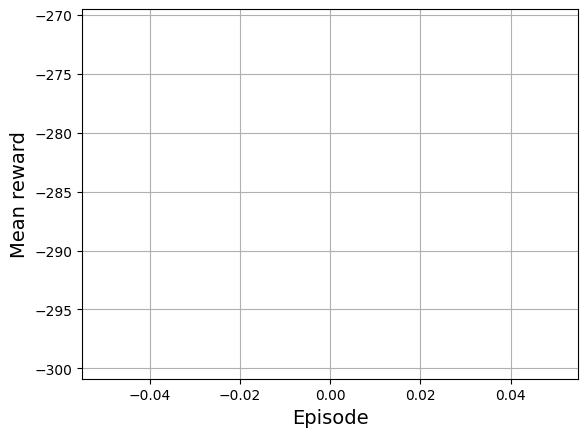

In [30]:
plt.plot(mean_rewards)
plt.xlabel("Episode")
plt.ylabel("Mean reward")
plt.grid()
plt.show()

In [33]:
def lander_render_policy_net(model, n_max_steps=500, seed=42):
  frames = []
  env = gym.make("LunarLander-v3", render_mode="rgb_array")
  tf.random.set_seed(seed)
  np.random.seed(seed)
  obs, info = env.reset()
  for step in range(n_max_steps):
    frames.append(env.render())
    probas = model.predict(obs[np.newaxis])
    logits = tf.math.log(probas + tf.keras.backend.epsilon())
    action = tf.random.categorical(logits, num_samples=1)
    obs, reward, done, truncated, info = env.step(action[0, 0].numpy())
    if done or truncated:
      break
  env.close()
  return frames

In [34]:
frames = lander_render_policy_net(model, seed=42)
plot_animation(frames)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━

# Referência
Hands-on ML with Scikit-Learn, Keras & TF by Aurelien Geron